In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import utils.misc as misc
import datetime as dt

# Forecasting SPX by using Macro Data

### Equity allocation as a predictor of SPX returns

We assume that all investors allocate all of their capital into 3 classes of assets:
1. Cash
2. Bonds
3. Equities

Investors switch between assets by buying/selling them through an auction-like process. For example, if equities offer unattractive returns compared to bonds and cash, investors will sell stocks until stock prices are low enough that they become attractive to a willing buyer.

The market price is therefore the current exchange rate between an asset and cash.

We define the supply of an asset as the total market value of the asset (e.g. market cap for stocks). 

The supply of an asset class relative to other asset classes should reflect the prevailing opinion of investors towards that asset class. For example, if no investors are willing to hold equities at its current price, the market price of stocks (reflected as the SP500 index SPX) will fall until a willing buyer is found. Therefore, the market cap of all equities, which indicates the 'supply' of equities will fall.

We hypothesize that the allocation of investor capital towards equities is mean-reverting. 

The allocation of investor capital towards equities is the relative supply of equities compared to cash and bonds.

\begin{equation}
    \text{Allocation towards equities} = \frac{\text{sum of equities}}{\text{sum of bonds and cash} + \text{sum of equities}}
\end{equation}

The macro data are downloaded from FRED.

310


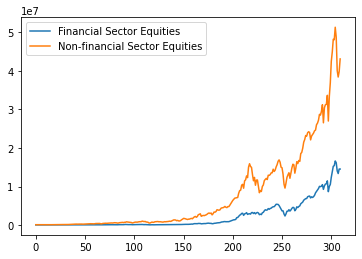

In [3]:
# for market cap of equities, we use the 2 following series:
# Nonfinancial Corporate Business; Corporate Equities; Liability, Level: https://fred.stlouisfed.org/series/NCBEILQ027S
# Domestic Financial Sectors; Corporate Equities; Liability, Level: https://fred.stlouisfed.org/series/FBCELLQ027S

e_df = pd.read_csv('datasets/macro_data/equities.csv')
e_arr = ['NCBEILQ027S', 'FBCELLQ027S']
print(len(e_df))

for f in e_arr:
    e_df = e_df[e_df[f] != "."]


e_df[e_arr] = e_df[e_arr].astype('float')



e_df['FBCELLQ027S'].plot(label='Financial Sector Equities')
e_df['NCBEILQ027S'].plot(label='Non-financial Sector Equities')
plt.legend()
plt.show()


310


[]

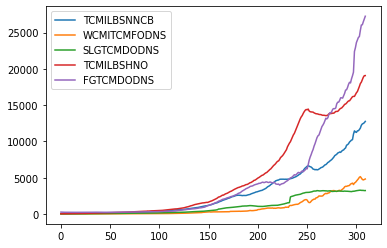

In [4]:
# for supply of bonds and cash, we use the 3 following series:
# Nonfinancial Corporate Business; Debt Securities and Loans; Liability, Level (TCMILBSNNCB): https://fred.stlouisfed.org/series/TCMILBSNNCB
# Rest of the World; Debt Securities and Loans; Liability, Level (WCMITCMFODNS): https://fred.stlouisfed.org/series/WCMITCMFODNS
# State and Local Governments; Debt Securities and Loans; Liability, Level (SLGTCMDODNS): https://fred.stlouisfed.org/series/SLGTCMDODNS
# Households and Nonprofit Organizations; Debt Securities and Loans; Liability, Level (TCMILBSHNO): https://fred.stlouisfed.org/series/TCMILBSHNO
# Federal Government; Debt Securities and Loans; Liability, Level (FGTCMDODNS): https://fred.stlouisfed.org/series/FGTCMDODNS

b_df = pd.read_csv('datasets/macro_data/bonds.csv')
print(len(b_df))

b_arr = ['TCMILBSNNCB','WCMITCMFODNS','SLGTCMDODNS','TCMILBSHNO','FGTCMDODNS']

for f in b_arr:
    b_df = b_df[b_df[f] != '.']

b_df[b_arr] = b_df[b_arr].astype('float')


for f in b_arr:
    b_df[f].plot(label=f)
plt.legend()
plt.plot()

We can then calculate the equity allocation (% of capital invested in equities relative to bonds and cash).
\begin{equation}
    \text{Allocation towards equities} = \frac{\text{sum of equities}}{\text{sum of bonds and cash} + \text{sum of equities}}
\end{equation}

In [5]:
df = pd.merge(b_df, e_df)
df['bond_sum'] = np.sum([df[f] for f in b_arr], axis=0)
# equity sum is divided by 1000 since the data is given in $ million compared to $ billion for bond/cash data.
df['equity_sum'] = np.sum([df[f] for f in e_arr], axis=0) / 1000
df['equity_allocation'] = df['equity_sum'] / (df['equity_sum'] + df['bond_sum'])
df.describe()

,TCMILBSNNCB,WCMITCMFODNS,SLGTCMDODNS,TCMILBSHNO,FGTCMDODNS,NCBEILQ027S,FBCELLQ027S,bond_sum,equity_sum,equity_allocation
count,292.000000,292.000000,292.000000,292.000000,292.000000,2.920000e+02,2.920000e+02,292.000000,292.000000,292.000000
mean,3080.864082,941.802973,1154.764918,5358.963842,4669.905404,8.013033e+06,2.355015e+06,15206.301219,10368.048000,0.356590
std,3339.426333,1331.462923,1205.472966,5905.335721,6413.837984,1.091667e+07,3.595761e+06,17819.133250,14494.397054,0.072556
min,44.653000,5.520000,12.635000,29.442000,220.012000,9.414100e+04,4.821600e+04,337.768000,143.064000,0.219968
25%,274.290000,43.127750,122.687250,411.748750,305.480000,6.498785e+05,9.557300e+04,1161.325250,762.117250,0.291763
50%,1826.095000,298.471000,739.621000,2548.896000,1965.175500,2.242706e+06,3.551145e+05,7381.520000,2612.700000,0.363092
75%,5003.610750,1269.286750,2497.699750,10947.435750,5277.405250,1.291363e+07,3.612476e+06,25007.194000,16431.087250,0.411838
max,12754.437000,5141.514000,3274.124000,19068.887000,27248.228000,5.134122e+07,1.663964e+07,67111.558000,67980.856000,0.518172


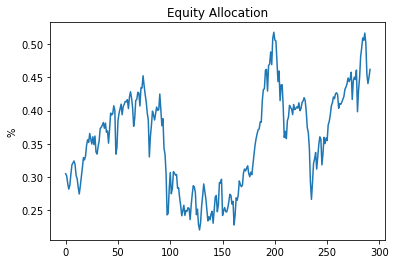

In [6]:
df1 = df[['DATE', 'equity_allocation']].copy()
df1['equity_allocation'].plot()
plt.title('Equity Allocation')
plt.ylabel('%')
plt.show()

To determine if equity allocation has any predictive power, we compare the equity allocation to subsequent 10-year SPX returns.

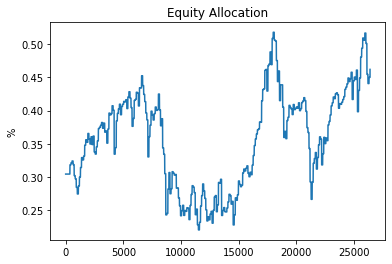

In [7]:
# prepare equity allocation curve for comparison

# convert date to datetime
df1['DATE'] = pd.to_datetime(df1['DATE'])

# start from 1950
df1 = df1[df1['DATE'] >= dt.datetime(1950, 1, 1)]

# fill in the missing days with previous value (no interpolation)
df1 = df1.set_index('DATE')
df1 = df1.resample('D').ffill()
df1.reset_index(inplace=True)
df1.rename(columns={'index': 'DATE'}, inplace=True)

df1['equity_allocation'].plot()
plt.title('Equity Allocation')
plt.ylabel('%')
plt.show()


SPX is the SP500 index. We use a concatenation of data from yahoo finance (^GSPC) and datahub.io (https://datahub.io/core/s-and-p-500).

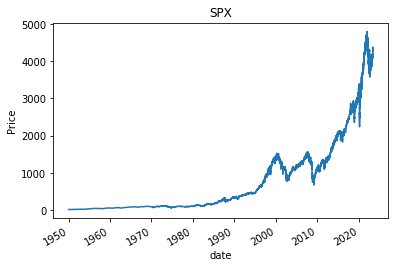

In [8]:
df2 = pd.read_csv('datasets/macro_data/SPX.csv')

df2 = misc.clean_df(df2)
df2 = df2[df2['date'] >= dt.datetime(1950, 1, 1)]
df2 = df2.set_index('date')
df2['SPX'].plot()
plt.ylabel('Price')
plt.title('SPX')
plt.show()

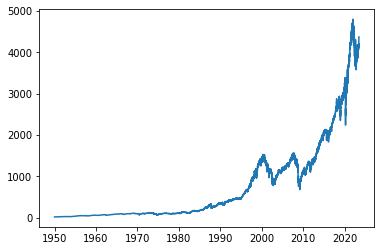

In [9]:
# fill in SPX returns to daily values using forward fill (previous value)
df2 = df2.resample('D').ffill()
df2.reset_index(inplace=True)
df2.rename(columns={'index': 'DATE'}, inplace=True)
plt.plot(df2['date'], df2['SPX'])
plt.show()

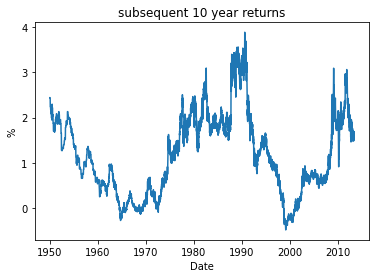

In [10]:
# Calcuate subsequent 10 year returns
# Since data has been filled to daily frequency, we can simply calculate returns of a rolling window of 3653 days to find 10 yr returns

def func(arr):
    '''
    Calculate total return from price series as last price / first price - 1
    '''
    return arr[-1] / arr[0] - 1

# calculate returns
df2['ret'] = df2['SPX'].rolling(3653).apply(func, raw=True)

# shift forward so that we are looking at subsequent 10 yr returns
df2['ret'] = df2['ret'].shift(-3653)

df2['DATE'] = df2['date']
df2 = df2.dropna()

plt.plot(df2['DATE'], df2['ret'])
plt.xlabel('Date')
plt.ylabel('%')
plt.title('subsequent 10 year returns')
plt.show()

We merge the 2 dataframes and remove duplicates to ensure 1-to-1 comparison.

Note that our hypothesis is that the equity allocation is mean-reverting. This means that is the equity allocation of investors is higher than historical average, investors will reduce their allocation by selling their equity holdings and vice versa. This implies that if the equity allocation is high, the subsequent returns of SPX should be low and vice versa. Therefore, we should plot the inverse of SPX returns to compare to the equity allocation series.

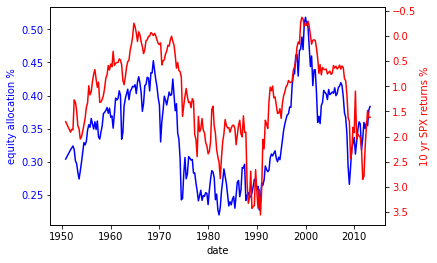

In [11]:
df3 = pd.merge(df1, df2)
df3.drop_duplicates(subset='equity_allocation', inplace=True)

fig, ax1 = plt.subplots()

color = 'blue'
ax1.set_xlabel('date')
ax1.set_ylabel('equity allocation %', color=color)
ax1.plot(df3['DATE'], df3['equity_allocation'], color=color)
ax1.tick_params(axis='y', labelcolor=color)


color = 'red'
ax2 = ax1.twinx()
ax2.set_ylabel('10 yr SPX returns %', color=color)
ax2.plot(df3['DATE'], df3['ret'], color=color)
ax2.invert_yaxis()
ax2.tick_params(axis='y', labelcolor=color)


plt.show()



The graph shows a strong relationship between equity allocation and subsequent 10 yr SPX returns.

We can further quantify the relationship by doing a linear regression.

R-squared value: 0.7094458078934378


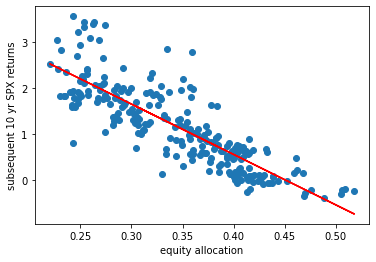

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Assuming you have a DataFrame named 'df' with two columns 'x' and 'y'
x = df3['equity_allocation'].values.reshape(-1, 1)
y = df3['ret'].values.reshape(-1, 1)

# Create a linear regression model and fit it to the data
reg = LinearRegression()
reg.fit(x, y)

# Make predictions using the fitted model
y_pred = reg.predict(x)

# Calculate the R-squared value
r2 = r2_score(y, y_pred)

print("R-squared value:", r2)

plt.scatter(df3['equity_allocation'], df3['ret'])
plt.ylabel('subsequent 10 yr SPX returns')
plt.xlabel('equity allocation')
plt.plot(x, y_pred, color='red')
plt.show()

We can see that equity allocation has a strong linear relationship with subsequent 10 yr SPX returns.

While this relationship may not be directly useful for a short-term market timing strategy, it means that we can use equity allocation as a way to gauge the general market sentiment or regime for a time period.

We can probably improve the prediction by using inflation rate and interest rate, since these metrics determine the return on cash and bonds.

### Unemployment as an indicator of recession

We hypothesize that the unemployment rate should be high during a recession. While the unemployment rate is a lagging indicator, the gradient of unemployment rate can be a leading indicator.

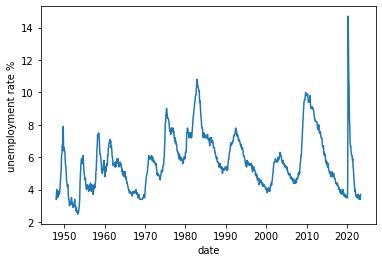

In [20]:
df = pd.read_csv('datasets/macro_data/unemployment_rate.csv')
df['DATE'] = pd.to_datetime(df['DATE'])

plt.plot(df['DATE'], df['UNRATE'])
plt.ylabel('unemployment rate %')
plt.xlabel('date')
plt.show()

We want to calculate the gradient of the unemployment rate by using the moving average. We define rising unemployment when the unemployment crosses above its 12 month moving average and vice versa. 

We theorise that rising unemployment signifies an impending recession, and falling unemployment implied recovery.

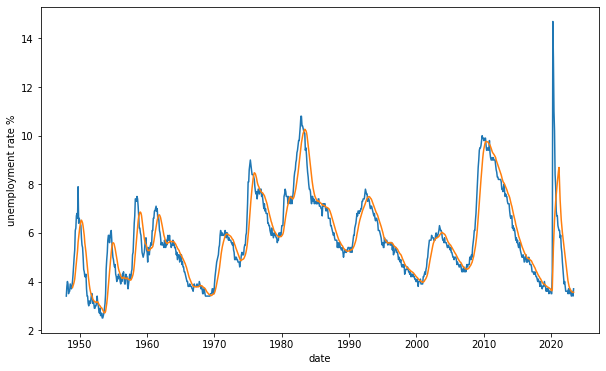

In [25]:
df['ma'] = df['UNRATE'].rolling(12).mean()
diff = df['UNRATE'] - df['ma']
df['grad'] = [0 if f > 0 else 1 for f in diff ]
plt.figure(figsize=(10, 6))
plt.plot(df['DATE'], df['UNRATE'])
plt.plot(df['DATE'], df['ma'])
plt.ylabel('unemployment rate %')
plt.xlabel('date')
plt.show()

We want to compare returns of SPX during periods when unemployment is rising and when it is falling from the simple indicator that we have made.

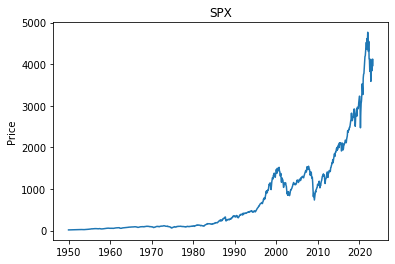

,DATE,UNRATE,ma,grad,date,SPX,ret
0,1950-01-01,6.5,6.233333,0,1950-01-01,16.880000,0.019550
1,1950-02-01,6.4,6.375000,0,1950-02-01,17.210000,0.008135
2,1950-03-01,6.3,6.483333,1,1950-03-01,17.350000,0.028242
3,1950-04-01,5.8,6.525000,1,1950-04-01,17.840000,0.033632
4,1950-05-01,5.5,6.475000,1,1950-05-01,18.440000,0.016269
...,...,...,...,...,...,...,...
875,2022-12-01,3.5,3.641667,1,2022-12-01,4076.570068,-0.058154
876,2023-01-01,3.4,3.591667,1,2023-01-01,3839.500000,0.072851
877,2023-02-01,3.6,3.575000,0,2023-02-01,4119.209961,-0.040741
878,2023-03-01,3.5,3.566667,1,2023-03-01,3951.389893,0.039966


In [33]:
df2 = pd.read_csv('datasets/macro_data/SPX.csv')

df2 = misc.clean_df(df2)
df2 = df2[df2['date'] >= dt.datetime(1950, 1, 1)]
df2 = df2.set_index('date')

df2 = df2.resample('D').ffill()
df2.reset_index(inplace=True)
df2.rename(columns={'index': 'DATE'}, inplace=True)
df2['DATE'] = df2['date']

df = pd.merge(df, df2)
# monthly returns of SPX
# note that we are taking subsequent returns by shifting forward
df['ret'] = df['SPX'].pct_change().shift(-1)
df.dropna(inplace=True)



df

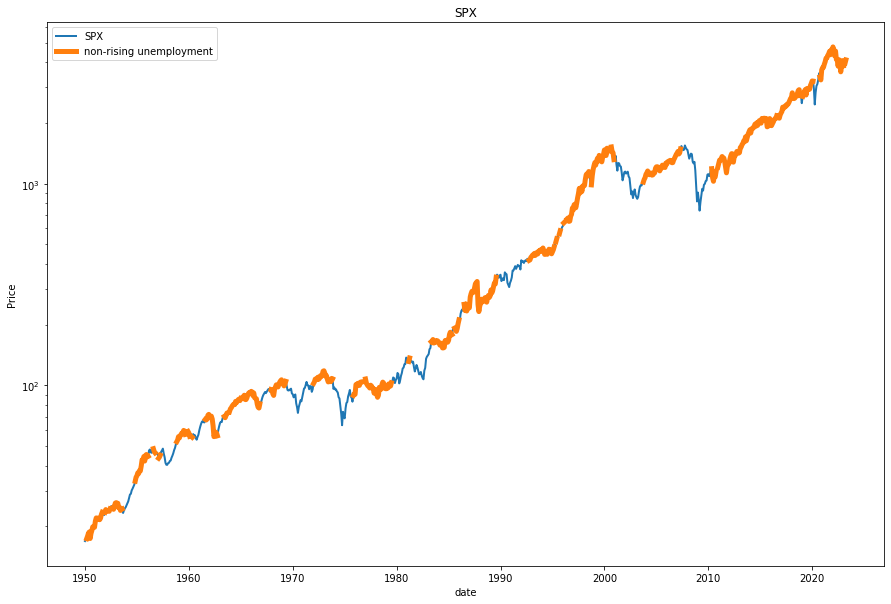

In [54]:
plt.figure(figsize=(15, 10))
plt.yscale('log')
plt.plot(df['DATE'], df['SPX'], linewidth=2, label='SPX')
ind = [np.nan if f == 0 else f for f in df['grad'] * df['SPX']]
plt.plot(df['DATE'], ind, linewidth=5, label='non-rising unemployment')
plt.ylabel('Price')
plt.xlabel('date')
plt.title('SPX')
plt.legend()
plt.show()

We can see that rising unemployment does correspond to recessions. However, we note that it does not directly help us  avoid negative returns as SPX generally recovers before unemployment.

However, this indicator is still useful for judging market regimes. For example, during recessionary periods, we may wish to switch to a different trading strategy compared to strategies used in an extended bull run.